## Task1: Acquire, Preprocess and Analyze the data 

### Import Dataset

In [2]:
import numpy as np
import pandas as pd 
from scipy.io.arff import loadarff 
from scipy.io import arff
%matplotlib inline                                  
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace     #for debugging 
hepatitis=pd.read_csv(r"hepatitis.data")
raw_data = loadarff(r"messidor_features.arff")
messidor=pd.DataFrame(raw_data[0])

In [3]:
#rename the columns

hepatitis=hepatitis.rename(columns={'2':"Class",'30':'Age','2.1':'Sex','1':'Steroid','2.2':'Antivirals',
                                    '2.3':'Fatique','2.4':'Malaise','2.5':"Anorexia",'1.1':'Liver Big',
                                   '2.6':"Liver Firm",'2.7':"Spleen Palpable",'2.8':"Spiders","2.9":"Ascites","2.10":"Varices",
                                   '1.00':"Bilirubin","85":"Alk Phosphate","18":"Sgot","4.0":"Albumin",
                                    "?":"Protime","1.2":"Histology"})

In [4]:
# rename the columns
messidor.set_axis(["quality", "pre-screen", "MA0.5", "MA0.6", "MA0.7", "MA0.8", "MA0.9",
                            "MA1", "exudates0.3", "exudates0.4", "exudates0.5", "exudates0.6", "exudates0.7", "exudates0.8", 
                            "exudates0.9", "exudates1", "euc_distance", "diameter", "AM\FM", "sign", ], axis = 1,inplace = True )

### Clean the Data

In [4]:
# drop the missing values
feature_list=hepatitis.columns.values.tolist()
threshold=20
features_drop=[]
for i in feature_list:
    if "?" in hepatitis[i].values.tolist():
        if hepatitis[i].value_counts()["?"]>threshold:
             features_drop.append(i)       
features_drop
hepatitis=hepatitis.drop(columns=features_drop)
hepatitis=hepatitis[~hepatitis.eq('?').any(1)]
hepatitis=hepatitis.drop_duplicates()
#hepatitis.shape

In [5]:
#drop the missing values
feature_list=messidor.columns.values.tolist()
threshold=150
features_drop=[]
for i in feature_list:
    if "N/A" in messidor[i].values:
        if messidor[i].value_counts()["N/A"]>threshold:
            features_drop.append(i)       
features_drop
messidor=messidor.drop(columns=features_drop)
messidor=messidor[~messidor.eq('N/A').any(1)]
messidor=messidor.drop_duplicates()
len(messidor)

C:\Users\liuru\AppData\Local\Temp\ipykernel_7180\1775947884.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "N/A" in messidor[i].values:


1146

### Basic Statistics of Dataset-Hepatitis

In [44]:
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from datascience import *

In [45]:
hepatitis["Class"].value_counts()

2    104
1     24
Name: Class, dtype: int64

In [46]:
hepatitis.shape[0]

128

In [47]:
#only sgot and Age are numerical features.
statistical_fact_hepatitis=Table().with_columns("Seasons",make_array("Age","Sgot"),
                                     "Mean",make_array(hepatitis["Age"].mean(),hepatitis["Sgot"].mean()),
                                     "Minimum",make_array(hepatitis["Age"].min(),hepatitis["Sgot"].min()),
                                     "Maximum",make_array(hepatitis["Age"].max(),hepatitis["Sgot"].max()))
statistical_fact_hepatitis

Seasons,Mean,Minimum,Maximum
Age,40.8906,7,78
Sgot,3.30641e+286,100,98


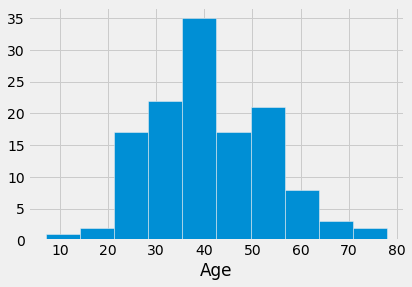

In [48]:
plots.hist(hepatitis["Age"]);
plots.xlabel("Age");

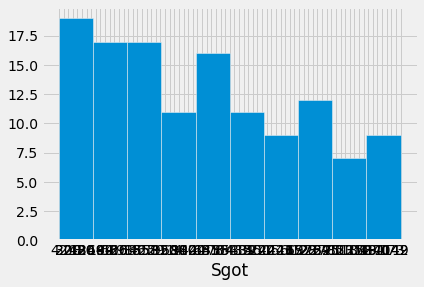

In [49]:
plots.hist(hepatitis["Sgot"])
plots.xlabel("Sgot");

### Basic Statistics of Dataset-Hepatitis

In [50]:
messidor["quality"].value_counts()

1.0    1142
0.0       4
Name: quality, dtype: int64

## Task2: Implementation of KNN and DT

### K-Nearest Neighbors

In [6]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1) 


class KNN:
    def __init__(self, K=1,dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y)+1
        #self.C = np.max(y)
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C)
            #y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C+1)[1:] #counts the number of instances of each class in the K-closest training samples
        y_prob /= self.K
        return y_prob,knns
    
    def evaluate_acc(self, y_pred, y_test):
        accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
        return accuracy

## Decision Tree

In [7]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

In [8]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [9]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

In [10]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_gini_index, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass

In [11]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

In [12]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

In [13]:
def evaluate_acc(self, y_pred, y_test):
    accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
    return accuracy

DecisionTree.evaluate_acc = evaluate_acc

## Task3: Running Experiments

### 3.1 Accuracy of KNN and DT on Two Dataset

### Hepatitis-KNN

In [59]:
#Split the dataset
x,y=hepatitis.to_numpy()[:,1:],hepatitis["Class"].to_numpy()
x=x.astype(float)
y=y.astype(int)-1
(N,D), C = x.shape, np.max(y)+1
inds = np.random.permutation(N)

x_train, y_train = x[inds[:100]], y[inds[:100]] #inds:random permutation
x_test, y_test = x[inds[100:]], y[inds[100:]]

#Further split the training data into train_tr and train_va
x_train_tr, y_train_tr = x_train[:50], y_train[:50]
x_train_va, y_train_va = x_train[50:], y_train[50:]

best K = 7, test accuracy = 0.8928571428571429


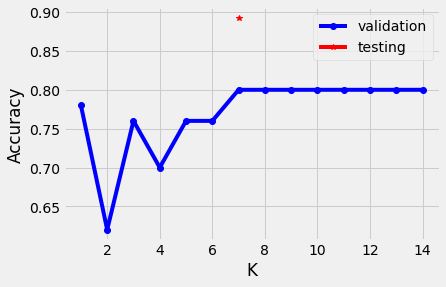

In [60]:
## Choosing the best hyperparameter
model_choices=[] # save k values
valid_acc = [] #save validation accuracy
n_valid = y_train_va.shape[0]

for k in range(1,15):
    knn = KNN(K=k) # create a KNN object (OOP)
    
    y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va) # bug fixed
    y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
   # y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)+1
    accuracy = np.sum(y_train_va_pred == y_train_va, dtype = float)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))] #use index to see what's best K value
knn = KNN(K=best_valid_K)
y_test_prob_knn,_ = knn.fit(x_train, y_train).predict(x_test)
y_test_pred_knn = np.argmax(y_test_prob_knn, axis=-1)
#y_test_pred = np.argmax(y_test_prob, axis=-1)+1
test_accuracy_hep_knn = np.sum(y_test_pred_knn == y_test)/y_test.shape[0]
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy_hep_knn}')

plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy_hep_knn, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('heptisis-knn.png',dpi=300,bbox_inches='tight')

### Hepatitis-Decision Tree

best depth = 2, test accuracy = 0.8928571428571429


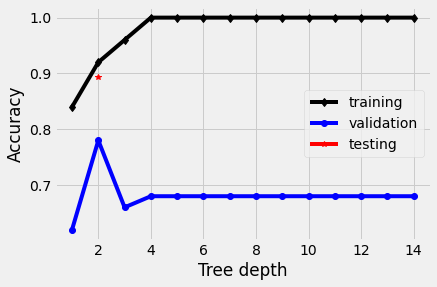

In [61]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 15):
    dt = DecisionTree(max_depth=k) # create a KNN object (OOP)

    y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob_dt = dt.fit(x_train, y_train).predict(x_test)
y_test_pred_dt = np.argmax(y_test_prob_dt, axis=-1)
test_accuracy_hep_dt = np.sum(y_test_pred_dt == y_test)/y_test.shape[0]
print(f'best depth = {best_depth}, test accuracy = {test_accuracy_hep_dt}')

plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy_hep_dt, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('heptisis-dt',dpi=300,bbox_inches='tight')

### Messidor-KNN

In [62]:
# Transform the sign column (independent variable) into numerical form for prediction 
def transform(s):
    return int.from_bytes(s, "big") - 48

a=messidor.to_numpy()[:,:-1]
b=messidor["sign"].apply(transform).to_numpy()
a=a.astype(float)
b=b.astype(int)

# temp = messidor['Class'].astype(str)
# lookupTable, indexed_dataSet = np.unique(temp, return_inverse=True)
# indexed_dataSet

In [63]:
#Split the dataset into train and test
(N,D), C = a.shape, np.max(b)
(num_instances, num_features), num_classes = a.shape, np.max(b)+1
inds = np.random.permutation(N)
#N*(2/3)=764
a_train, b_train = a[inds[:764]], b[inds[:764]] #inds:random permutation
a_test, b_test = a[inds[764:]], b[inds[764:]]
#Further split the train dataset for choosing hyperparameter
a_train_tr, b_train_tr = a_train[:382], b_train[:382]
a_train_va, b_train_va = a_train[382:], b_train[382:]
#b_train_va.shape

best K = 14, test accuracy = 0.6544502617801047


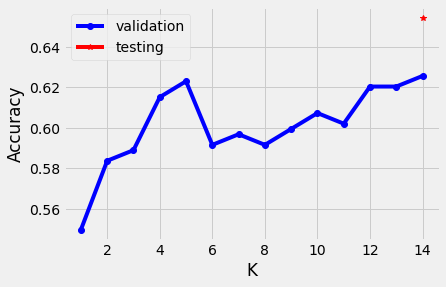

In [64]:
## Choosing the best hyperparameter
model_choices=[] # save k values
valid_acc = [] #save validation accuracy
n_valid = b_train_va.shape[0]

for k in range(1,15):
    knn = KNN(K=k) # create a KNN object (OOP)
    b_train_va_prob,_ = knn.fit(a_train_tr, b_train_tr).predict(a_train_va) # bug fixed
    b_train_va_pred = np.argmax(b_train_va_prob,axis=-1)
   # b_train_va_pred = np.argmax(b_train_va_prob,axis=-1)+1
    accuracy = np.sum(b_train_va_pred == b_train_va, dtype = float)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))] #use index to see what's best K value
knn = KNN(K=best_valid_K)
b_test_prob,_ = knn.fit(a_train, b_train).predict(a_test)
b_test_pred = np.argmax(b_test_prob, axis=-1)
#b_test_pred = np.argmax(b_test_prob, axis=-1)+1
test_accuracy_mes_knn = np.sum(b_test_pred == b_test)/b_test.shape[0]
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy_mes_knn}')

plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy_mes_knn, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('messidor-knn.png',dpi=300,bbox_inches='tight')

### Messidor-DT

best depth = 3, test accuracy = 0.599476439790576


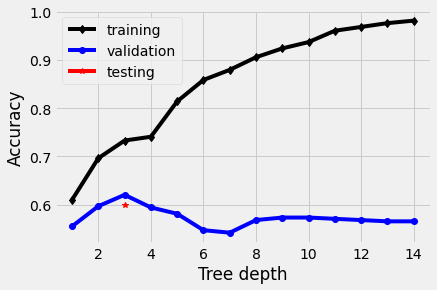

In [65]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = b_train_tr.shape[0]
n_valid = b_train_va.shape[0]

for k in range(1, 15):
    dt = DecisionTree(max_depth=k) # create a KNN object (OOP)

    b_train_tr_prob = dt.fit(a_train_tr, b_train_tr).predict(a_train_tr)
    b_train_tr_pred = np.argmax(b_train_tr_prob, axis=-1)
    acc_tr = np.sum(b_train_tr_pred == b_train_tr)/n_train

    b_train_va_prob = dt.fit(a_train_tr, b_train_tr).predict(a_train_va)
    b_train_va_pred = np.argmax(b_train_va_prob, axis=-1)
    acc_va = np.sum(b_train_va_pred == b_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
b_test_prob = dt.fit(a_train, b_train).predict(a_test)
b_test_pred = np.argmax(b_test_prob, axis=-1)
test_accuracy_mes_dt = np.sum(b_test_pred == b_test)/b_test.shape[0]
print(f'best depth = {best_depth}, test accuracy = {test_accuracy_mes_dt}')

plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy_mes_dt, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('messidor-DT.png',dpi=300,bbox_inches='tight')

#### compare the result of KNN and DT

##### Heptisis

In [19]:
# run knn 100 times
accuracy_knn = []
for i in range(100):
    #Split the dataset
    x,y=hepatitis.to_numpy()[:,1:],hepatitis["Class"].to_numpy()
    x=x.astype(float)
    y=y.astype(int)-1
    (N,D), C = x.shape, np.max(y)
    inds = np.random.permutation(N)
    x_train, y_train = x[inds[:100]], y[inds[:100]] #inds:random permutation
    x_test, y_test = x[inds[100:]], y[inds[100:]]

    #Further split the training data into train_tr and train_va
    x_train_tr, y_train_tr = x_train[:50], y_train[:50]
    x_train_va, y_train_va = x_train[50:], y_train[50:]
    
    ## Choosing the best hyperparameter
    model_choices=[] # save k values
    valid_acc = [] #save validation accuracy
    n_valid = y_train_va.shape[0]

    for k in range(1,15):
        knn = KNN(K=k) # create a KNN object (OOP)
        y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va) # bug fixed
        y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
       # y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)+1
        accuracy = np.sum(y_train_va_pred == y_train_va, dtype = float)/n_valid
        model_choices.append(k)
        valid_acc.append(accuracy)

    # use the best K to predict test data
    best_valid_K = model_choices[valid_acc.index(max(valid_acc))] #use index to see what's best K value
    knn = KNN(K=best_valid_K)
    y_test_prob_knn,_ = knn.fit(x_train, y_train).predict(x_test)
    y_test_pred_knn = np.argmax(y_test_prob_knn, axis=-1)
    #y_test_pred = np.argmax(y_test_prob, axis=-1)+1
    test_accuracy_hep_knn = np.sum(y_test_pred_knn == y_test)/y_test.shape[0]
    accuracy_knn.append(test_accuracy_hep_knn)

##### The following code may take 5 mimutes or more 

In [20]:
# run dt 100 times
accuracy_dt = []
for i in range(100):
    #Split the dataset
    x,y=hepatitis.to_numpy()[:,1:],hepatitis["Class"].to_numpy()
    x=x.astype(float)
    y=y.astype(int)-1
    (N,D), C = x.shape, np.max(y)
    inds = np.random.permutation(N)
    x_train, y_train = x[inds[:100]], y[inds[:100]] #inds:random permutation
    x_test, y_test = x[inds[100:]], y[inds[100:]]

    #Further split the training data into train_tr and train_va
    x_train_tr, y_train_tr = x_train[:50], y_train[:50]
    x_train_va, y_train_va = x_train[50:], y_train[50:]
    model_choices=[]
    train_acc = []
    valid_acc = []

    n_train = y_train_tr.shape[0]
    n_valid = y_train_va.shape[0]

    for k in range(1, 15):
        dt = DecisionTree(max_depth=k) # create a KNN object (OOP)

        y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
        y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
        acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

        y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
        y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
        acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

        model_choices.append(k)
        train_acc.append(acc_tr)
        valid_acc.append(acc_va)

    # use the best K to predict test data
    best_depth = model_choices[valid_acc.index(max(valid_acc))]
    dt = DecisionTree(max_depth=best_depth)
    y_test_prob_dt = dt.fit(x_train, y_train).predict(x_test)
    y_test_pred_dt = np.argmax(y_test_prob_dt, axis=-1)
    test_accuracy_hep_dt = np.sum(y_test_pred_dt == y_test)/y_test.shape[0]
    accuracy_dt.append(test_accuracy_hep_dt)

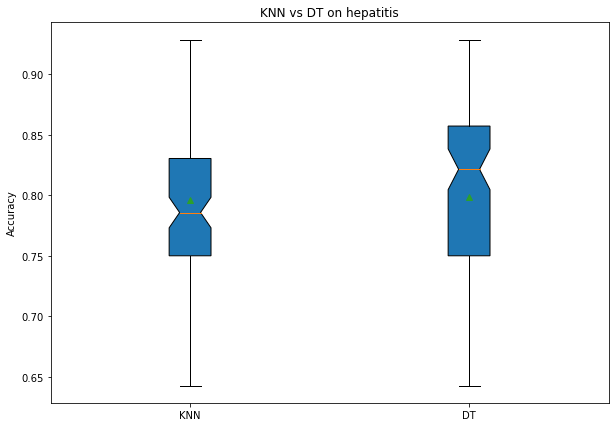

In [21]:
# compare knn and dt on data set heptisis by using box plot

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([accuracy_knn, accuracy_dt], patch_artist = True,
                notch ='True', vert = 1, showmeans = True)

ax.set_xticklabels(['KNN', 'DT'])
plt.title("KNN vs DT on hepatitis")
plt.ylabel("Accuracy")
plt.savefig('KNN vs DT on hepatitis.png',dpi='figure',bbox_inches='tight')

#### DT has higher mean value than KNN.

##### messidor

In [14]:
def transform(s):
        return int.from_bytes(s, "big") - 48
    
a=messidor.to_numpy()[:,:-1]
b=messidor["sign"].apply(transform).to_numpy()
a=a.astype(float)
b=b.astype(int)

In [15]:
# run knn 100 times
accuracy_knn = []
for i in range(100):
    #Split the dataset into train and test
    (N,D), C = a.shape, np.max(b)
    (num_instances, num_features), num_classes = a.shape, np.max(b)+1
    inds = np.random.permutation(N)
    #N*(2/3)=764
    a_train, b_train = a[inds[:764]], b[inds[:764]] #inds:random permutation
    a_test, b_test = a[inds[764:]], b[inds[764:]]
    #Further split the train dataset for choosing hyperparameter
    a_train_tr, b_train_tr = a_train[:382], b_train[:382]
    a_train_va, b_train_va = a_train[382:], b_train[382:]
    #b_train_va.shape
    
    ## Choosing the best hyperparameter
    model_choices=[] # save k values
    valid_acc = [] #save validation accuracy
    n_valid = b_train_va.shape[0]

    for k in range(1,15):
        knn = KNN(K=k) # create a KNN object (OOP)
        b_train_va_prob,_ = knn.fit(a_train_tr, b_train_tr).predict(a_train_va) # bug fixed
        b_train_va_pred = np.argmax(b_train_va_prob,axis=-1)
       # b_train_va_pred = np.argmax(b_train_va_prob,axis=-1)+1
        accuracy = np.sum(b_train_va_pred == b_train_va, dtype = float)/n_valid
        model_choices.append(k)
        valid_acc.append(accuracy)

    # use the best K to predict test data
    best_valid_K = model_choices[valid_acc.index(max(valid_acc))] #use index to see what's best K value
    knn = KNN(K=best_valid_K)
    b_test_prob,_ = knn.fit(a_train, b_train).predict(a_test)
    b_test_pred = np.argmax(b_test_prob, axis=-1)
    #b_test_pred = np.argmax(b_test_prob, axis=-1)+1
    test_accuracy_mes_knn = np.sum(b_test_pred == b_test)/b_test.shape[0]
    accuracy_knn.append(test_accuracy_mes_knn)

##### The following code may take 1 hour or more! You can change the range to reduce the time.

In [16]:
# run dt 10 times
accuracy_dt = []
for i in range(10): # change the number in range() to reduce time consumption
    #Split the dataset into train and test
    (N,D), C = a.shape, np.max(b)
    (num_instances, num_features), num_classes = a.shape, np.max(b)+1
    inds = np.random.permutation(N)
    #N*(2/3)=764
    a_train, b_train = a[inds[:764]], b[inds[:764]] #inds:random permutation
    a_test, b_test = a[inds[764:]], b[inds[764:]]
    #Further split the train dataset for choosing hyperparameter
    a_train_tr, b_train_tr = a_train[:382], b_train[:382]
    a_train_va, b_train_va = a_train[382:], b_train[382:]
    #b_train_va.shape
    
    model_choices=[]
    train_acc = []
    valid_acc = []

    n_train = b_train_tr.shape[0]
    n_valid = b_train_va.shape[0]

    for k in range(1, 15):
        dt = DecisionTree(max_depth=k) # create a KNN object (OOP)

        b_train_tr_prob = dt.fit(a_train_tr, b_train_tr).predict(a_train_tr)
        b_train_tr_pred = np.argmax(b_train_tr_prob, axis=-1)
        acc_tr = np.sum(b_train_tr_pred == b_train_tr)/n_train

        b_train_va_prob = dt.fit(a_train_tr, b_train_tr).predict(a_train_va)
        b_train_va_pred = np.argmax(b_train_va_prob, axis=-1)
        acc_va = np.sum(b_train_va_pred == b_train_va)/n_valid

        model_choices.append(k)
        train_acc.append(acc_tr)
        valid_acc.append(acc_va)

    # use the best K to predict test data
    best_depth = model_choices[valid_acc.index(max(valid_acc))]
    dt = DecisionTree(max_depth=best_depth)
    b_test_prob = dt.fit(a_train, b_train).predict(a_test)
    b_test_pred = np.argmax(b_test_prob, axis=-1)
    test_accuracy_mes_dt = np.sum(b_test_pred == b_test)/b_test.shape[0]
    
    accuracy_dt.append(test_accuracy_mes_dt)

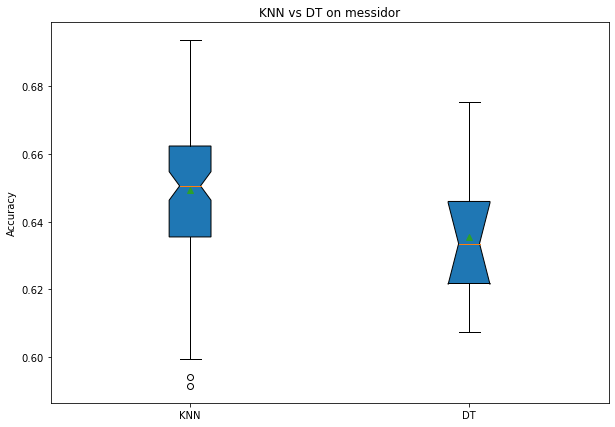

In [17]:
# compare knn and dt on data set heptisis by using box plot

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([accuracy_knn, accuracy_dt], patch_artist = True,
                notch ='True', vert = 1, showmeans = True)

ax.set_xticklabels(['KNN', 'DT'])
plt.title("KNN vs DT on messidor")
plt.ylabel("Accuracy")
plt.savefig('KNN vs DT on messidor.png',dpi='figure',bbox_inches='tight')

### 3.2 Test different K values and see how it affects the test data accuracy of KNN

In [ ]:
#accuracy under different K in heptisis

end = 15

#Split the dataset
x,y=hepatitis.to_numpy()[:,1:],hepatitis["Class"].to_numpy()
x=x.astype(float)
y=y.astype(int)-1
#print(x.dtype)
#x, y = hepatitis.drop(columns=["Class"]).values,hepatitis['Class'].values 
(N,D), C = x.shape, np.max(y)
#print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')
inds = np.random.permutation(N)
x_train, y_train = x[inds[:100]], y[inds[:100]] #inds:random permutation
x_test, y_test = x[inds[100:]], y[inds[100:]]
    
    
#Further split the training data into train_tr and train_va
x_train_tr, y_train_tr = x_train[:50], y_train[:50]
x_train_va, y_train_va = x_train[50:], y_train[50:]
    
    
## Choosing the best hyperparameter
model_choices=[] # save k values
valid_acc = [] #save validation accuracy
test_acc = [] #save the test accuracy
n_valid = y_train_va.shape[0]

for k in range(1,end):
    knn = KNN(K=k) # create a KNN object (OOP)
    y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va) # bug fixed
    y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
    # y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)+1
    accuracy = np.sum(y_train_va_pred == y_train_va, dtype = float)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)
    
    knn = KNN(K=k)
    y_test_prob, _ = knn.fit(x_train, y_train).predict(x_test)
    y_test_pred = np.argmax(y_test_prob, axis=-1)
    test_acc.append(knn.evaluate_acc(y_test_pred, y_test))

plt.plot(valid_acc, marker='o', color='blue', label='validation')
plt.plot(test_acc, marker='*', color='red', label='testing')
plt.title("accuracy under different K in heptisis")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.savefig('accuracy under different K in heptisis.png',dpi='figure',bbox_inches='tight')

In [ ]:
#Split the dataset into train and test
(N,D), C = a.shape, np.max(b)
(num_instances, num_features), num_classes = a.shape, np.max(b)+1
inds = np.random.permutation(N)
#N*(2/3)=764
a_train, b_train = a[inds[:764]], b[inds[:764]] #inds:random permutation
a_test, b_test = a[inds[764:]], b[inds[764:]]
#Further split the train dataset for choosing hyperparameter
a_train_tr, b_train_tr = a_train[:382], b_train[:382]
a_train_va, b_train_va = a_train[382:], b_train[382:]

## Choosing the best hyperparameter
model_choices=[] # save k values
valid_acc = [] #save validation accuracy
test_acc = [] #save the test accuracy
n_valid = b_train_va.shape[0]

for k in range(1,20):
    knn = KNN(K=k) # create a KNN object (OOP)
    b_train_va_prob,_ = knn.fit(a_train_tr, b_train_tr).predict(a_train_va) # bug fixed
    b_train_va_pred = np.argmax(b_train_va_prob,axis=-1)
   # b_train_va_pred = np.argmax(b_train_va_prob,axis=-1)+1
    accuracy = np.sum(b_train_va_pred == b_train_va, dtype = float)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)
    
    knn = KNN(K=k)
    b_test_prob, _ = knn.fit(a_train, b_train).predict(a_test)
    b_test_pred = np.argmax(b_test_prob, axis=-1)
    test_acc.append(knn.evaluate_acc(b_test_pred, b_test))

plt.plot(valid_acc, marker='o', color='blue', label='validation')
plt.plot(test_acc, marker='*', color='red', label='testing')
plt.title("accuracy under different K in messidor")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.savefig('accuracy under different K in messidor.png',dpi='figure',bbox_inches='tight')

## 3.3 Test different depth and see how it affects the test data accuracy of DT

In [ ]:
end = 15

#Split the dataset
x,y=hepatitis.to_numpy()[:,1:],hepatitis["Class"].to_numpy()
x=x.astype(float)
y=y.astype(int)-1
#print(x.dtype)
#x, y = hepatitis.drop(columns=["Class"]).values,hepatitis['Class'].values 
(N,D), C = x.shape, np.max(y)
#print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')
inds = np.random.permutation(N)
x_train, y_train = x[inds[:100]], y[inds[:100]] #inds:random permutation
x_test, y_test = x[inds[100:]], y[inds[100:]]
    
    
#Further split the training data into train_tr and train_va
x_train_tr, y_train_tr = x_train[:50], y_train[:50]
x_train_va, y_train_va = x_train[50:], y_train[50:]
    
model_choices=[]
train_acc = []
valid_acc = []
test_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 15):
    dt = DecisionTree(max_depth=k) # create a KNN object (OOP)

    y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)  
    
    dt = DecisionTree(max_depth=k)
    y_test_prob = dt.fit(x_train, y_train).predict(x_test)
    y_test_pred = np.argmax(y_test_prob, axis=-1)
    test_acc.append(dt.evaluate_acc(y_test_pred, y_test))


plt.plot(valid_acc, marker='o', color='blue', label='validation')
plt.plot(test_acc, marker='*', color='red', label='testing')
plt.title("accuracy under different depth in heptisis")
plt.xlabel("depth")
plt.ylabel("Accuracy")
plt.savefig('accuracy under different depth in heptisis.png',dpi='figure',bbox_inches='tight')

In [ ]:
def transform(s):
        return int.from_bytes(s, "big") - 48
    
a=messidor.to_numpy()[:,:-1]
b=messidor["sign"].apply(transform).to_numpy()
a=a.astype(float)
b=b.astype(int)

#Split the dataset into train and test
(N,D), C = a.shape, np.max(b)
(num_instances, num_features), num_classes = a.shape, np.max(b)+1
inds = np.random.permutation(N)
#N*(2/3)=764
a_train, b_train = a[inds[:764]], b[inds[:764]] #inds:random permutation
a_test, b_test = a[inds[764:]], b[inds[764:]]
#Further split the train dataset for choosing hyperparameter
a_train_tr, b_train_tr = a_train[:382], b_train[:382]
a_train_va, b_train_va = a_train[382:], b_train[382:]

model_choices=[]
train_acc = []
valid_acc = []
test_acc = []

n_train = b_train_tr.shape[0]
n_valid = b_train_va.shape[0]

for k in range(1, 15):
    dt = DecisionTree(max_depth=k) # create a KNN object (OOP)

    b_train_tr_prob = dt.fit(a_train_tr, b_train_tr).predict(a_train_tr)
    b_train_tr_pred = np.argmax(b_train_tr_prob, axis=-1)
    acc_tr = np.sum(b_train_tr_pred == b_train_tr)/n_train

    b_train_va_prob = dt.fit(a_train_tr, b_train_tr).predict(a_train_va)
    b_train_va_pred = np.argmax(b_train_va_prob, axis=-1)
    acc_va = np.sum(b_train_va_pred == b_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)
    
    dt = DecisionTree(max_depth=k)
    b_test_prob = dt.fit(a_train, b_train).predict(a_test)
    b_test_pred = np.argmax(b_test_prob, axis=-1)
    test_acc.append(dt.evaluate_acc(b_test_pred, b_test))

plt.plot(valid_acc, marker='o', color='blue', label='validation')
plt.plot(test_acc, marker='*', color='red', label='testing')
plt.title("accuracy under different depth in messidor")
plt.xlabel("depth")
plt.ylabel("Accuracy")
plt.savefig('accuracy under different depth in messidor.png',dpi='figure',bbox_inches='tight')

## 3.4 Different distance/cost functions for both models

##### euclidean vs manhattan

In [ ]:
#Split the dataset
x,y=hepatitis.to_numpy()[:,1:],hepatitis["Class"].to_numpy()
x=x.astype(float)
y=y.astype(int)-1
(N,D), C = x.shape, np.max(y)+1
inds = np.random.permutation(N)

x_train, y_train = x[inds[:100]], y[inds[:100]] #inds:random permutation
x_test, y_test = x[inds[100:]], y[inds[100:]]

#Further split the training data into train_tr and train_va
x_train_tr, y_train_tr = x_train[:50], y_train[:50]
x_train_va, y_train_va = x_train[50:], y_train[50:]

In [ ]:
## euclidean

model_choices=[] # save k values
valid_acc = [] #save validation accuracy
n_valid = y_train_va.shape[0]

for k in range(1,15):
    knn = KNN(K=k, dist_fn = euclidean) # create a KNN object (OOP)
    
    y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va) # bug fixed
    y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
   # y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)+1
    accuracy = np.sum(y_train_va_pred == y_train_va, dtype = float)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))] #use index to see what's best K value
knn = KNN(K=best_valid_K)
y_test_prob_knn,_ = knn.fit(x_train, y_train).predict(x_test)
y_test_pred_knn = np.argmax(y_test_prob_knn, axis=-1)
#y_test_pred = np.argmax(y_test_prob, axis=-1)+1
test_accuracy_hep_knn = np.sum(y_test_pred_knn == y_test)/y_test.shape[0]
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy_hep_knn}')

plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy_hep_knn, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("euclidean")
plt.legend(loc='best')
plt.savefig('heptisis-knn euclidean.png',dpi=300,bbox_inches='tight')

In [ ]:
## manhattan

model_choices=[] # save k values
valid_acc = [] #save validation accuracy
n_valid = y_train_va.shape[0]

for k in range(1,15):
    knn = KNN(K=k, dist_fn = manhattan) # create a KNN object (OOP)
    
    y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va) # bug fixed
    y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
   # y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)+1
    accuracy = np.sum(y_train_va_pred == y_train_va, dtype = float)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))] #use index to see what's best K value
knn = KNN(K=best_valid_K)
y_test_prob_knn,_ = knn.fit(x_train, y_train).predict(x_test)
y_test_pred_knn = np.argmax(y_test_prob_knn, axis=-1)
#y_test_pred = np.argmax(y_test_prob, axis=-1)+1
test_accuracy_hep_knn = np.sum(y_test_pred_knn == y_test)/y_test.shape[0]
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy_hep_knn}')

plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy_hep_knn, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("manhattan")
plt.legend(loc='best')
plt.savefig('heptisis-knn manhattan.png',dpi=300,bbox_inches='tight')

#### gini index vs entropy

In [ ]:
model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 15):
    dt = DecisionTree(max_depth=k, cost_fn= cost_gini_index) 

    y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob_dt = dt.fit(x_train, y_train).predict(x_test)
y_test_pred_dt = np.argmax(y_test_prob_dt, axis=-1)
test_accuracy_hep_dt = np.sum(y_test_pred_dt == y_test)/y_test.shape[0]
print(f'best depth = {best_depth}, test accuracy = {test_accuracy_hep_dt}')

plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy_hep_dt, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.title("gini index")
plt.legend(loc='best')
plt.savefig('heptisis-dt gini index',dpi=300,bbox_inches='tight')

In [ ]:
# entropy
model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 15):
    dt = DecisionTree(max_depth=k, cost_fn= cost_entropy) 

    y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob_dt = dt.fit(x_train, y_train).predict(x_test)
y_test_pred_dt = np.argmax(y_test_prob_dt, axis=-1)
test_accuracy_hep_dt = np.sum(y_test_pred_dt == y_test)/y_test.shape[0]
print(f'best depth = {best_depth}, test accuracy = {test_accuracy_hep_dt}')

plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy_hep_dt, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.title("entropy")
plt.legend(loc='best')
plt.savefig('heptisis-dt entropy',dpi=300,bbox_inches='tight')

## 3.5 Important features of KNN

In [ ]:
fnames = list(hepatitis)[1:]


from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression



model = LinearRegression()
model.fit(x_train, y_train)
importance_lr = model.coef_
lr_importances = pd.Series(importance_lr, index=fnames)
plt.bar(fnames, importance_lr)
plt.xticks(range(x.shape[1]), fnames,rotation=90)
plt.title("Important Features of KNN Using Linear Regression")
plt.savefig('Important features of KNN using linear regression.png',dpi='figure',bbox_inches='tight')
plt.show()

indices_lr = (-importance_lr).argsort()[:2]
lr_two_features = fnames[indices_lr[0]],fnames[indices_lr[1]]
print("The 2 important features are", lr_two_features[0], "and", lr_two_features[1])

## 3.6 Important features of DT

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time

forest = RandomForestClassifier(random_state=0)
forest.fit(x_train, y_train)


start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

forest_importances = pd.Series(importances, index=fnames)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Important Features Using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.savefig('Important Features of DT Using MDI.png',dpi='figure',bbox_inches='tight')
fig.tight_layout()



indices_dt = (-importances).argsort()[:2]
two_features = fnames[indices_dt[0]],fnames[indices_dt[1]]
print("The 2 important features are", two_features[0], "and", two_features[1])

## 3.7 Decision boundary

In [ ]:
## KNN

#Split the dataset
x,y=hepatitis.to_numpy()[:,1:],hepatitis["Class"].to_numpy()
x=x.astype(float)
y=y.astype(int)-1
(N,D), C = x.shape, np.max(y)+1
inds = np.random.permutation(N)

x_train, y_train = x[inds[:100]], y[inds[:100]] #inds:random permutation
x_test, y_test = x[inds[100:]], y[inds[100:]]

x1in, x2in = indices
x_train2 = x_train[:, [x1in, x2in]]

x0v = np.linspace(np.min(x[:,x1in]), np.max(x[:,x1in]), 200)
x1v = np.linspace(np.min(x[:,x2in]), np.max(x[:,x2in]), 200)

# to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

k = best_valid_K
model = KNN(K=k)

y_train_prob = np.zeros((y_train.shape[0], C))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

y_prob_all, _ = model.fit(x_train2, y_train).predict(x_all)


y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1 


temp1 = np.zeros((y_train_prob.shape[0],y_train_prob.shape[1]+1))
temp1[:,:-1] = y_train_prob

temp2 = np.zeros((y_pred_all.shape[0],y_pred_all.shape[1]+1))
temp2[:,:-1] = y_pred_all

plt.clf()
plt.scatter(x_train2[:,0], x_train2[:,1], c=temp1, marker='o', alpha=1)
    
plt.scatter(x_all[:,0], x_all[:,1], c=temp2, marker='.', alpha=0.01)


plt.ylabel(two_features[0])
plt.xlabel(two_features[1])
plt.savefig('decision_boundaries_KNN'+str(k)+'.png', dpi=300, bbox_inches='tight') 

In [ ]:
## DT

x1dt, x2dt = indices_dt
x_traindt2 = x_train[:, [x1dt, x2dt]]

x0v = np.linspace(np.min(x[:,x1dt]), np.max(x[:,x1dt]), 200)
x1v = np.linspace(np.min(x[:,x2dt]), np.max(x[:,x2dt]), 200)

# to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

k = best_depth
model = DecisionTree(max_depth=best_depth)

y_train_prob = np.zeros((y_train.shape[0], C))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

y_prob_all = model.fit(x_traindt2, y_train).predict(x_all)


y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1 


temp1 = np.zeros((y_train_prob.shape[0],y_train_prob.shape[1]+1))
temp1[:,:-1] = y_train_prob

temp2 = np.zeros((y_pred_all.shape[0],y_pred_all.shape[1]+1))
temp2[:,:-1] = y_pred_all

plt.clf()
plt.scatter(x_traindt2[:,0], x_traindt2[:,1], c=temp1, marker='o', alpha=1)
    
plt.scatter(x_all[:,0], x_all[:,1], c=temp2, marker='.', alpha=0.01)


plt.ylabel(lr_two_features[0])
plt.xlabel(lr_two_features[1])
plt.savefig('decision_boundaries_DT'+str(k)+'.png', dpi=300, bbox_inches='tight')

#  Weighted KNN

In [22]:
class WEIGHTED_KNN:
    def __init__(self, K=1,dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y)+1
        #self.C = np.max(y)
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        knns = np.zeros((num_test, self.K), dtype=int)
        
        similarity = np.zeros((num_test, self.K), dtype=float)
        
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            #compute the similarity for x(n)
            similarity[i,:] = 1/(distances[i][knns[i,:]])
            #compute the sum of Wk * identity function
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], similarity[i,:], minlength = self.C)
            #divided by Wk
            y_prob[i,:] = y_prob[i,:]/ sum(similarity[i,:])
        return y_prob,knns
    
    def evaluate_acc(self, y_pred, y_test):
        accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
        return accuracy

In [23]:
#run unweighted knn on hepsitis 1000 times
accuracy_unweighted = []
for i in range(1000):
    #Split the dataset
    x,y=hepatitis.to_numpy()[:,1:],hepatitis["Class"].to_numpy()
    x=x.astype(float)
    y=y.astype(int)-1
    #print(x.dtype)
    #x, y = hepatitis.drop(columns=["Class"]).values,hepatitis['Class'].values 
    (N,D), C = x.shape, np.max(y)
    #print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')
    inds = np.random.permutation(N)
    x_train, y_train = x[inds[:100]], y[inds[:100]] #inds:random permutation
    x_test, y_test = x[inds[100:]], y[inds[100:]]
    
    
    #Further split the training data into train_tr and train_va
    x_train_tr, y_train_tr = x_train[:50], y_train[:50]
    x_train_va, y_train_va = x_train[50:], y_train[50:]
    
    
    ## Choosing the best hyperparameter
    model_choices=[] # save k values
    valid_acc = [] #save validation accuracy
    n_valid = y_train_va.shape[0]

    for k in range(1,15):
        knn = KNN(K=k) # create a KNN object (OOP)
        y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va) # bug fixed
        y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
       # y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)+1
        accuracy = np.sum(y_train_va_pred == y_train_va, dtype = float)/n_valid
        model_choices.append(k)
        valid_acc.append(accuracy)

    # use the best K to predict test data
    best_valid_K = model_choices[valid_acc.index(max(valid_acc))] #use index to see what's best K value
    knn = KNN(K=best_valid_K)
    y_test_prob_knn,_ = knn.fit(x_train, y_train).predict(x_test)
    y_test_pred_knn = np.argmax(y_test_prob_knn, axis=-1)
    #y_test_pred = np.argmax(y_test_prob, axis=-1)+1
    test_accuracy_hep_knn = np.sum(y_test_pred_knn == y_test)/y_test.shape[0]
    accuracy_unweighted.append(test_accuracy_hep_knn)
    #print(f'best K = {best_valid_K}, test accuracy = {test_accuracy_hep_knn}')

In [24]:
#run weighted knn on hepsitis 1000 times
accuracy_weighted = []
for i in range(1000):
    #Split the dataset
    x,y=hepatitis.to_numpy()[:,1:],hepatitis["Class"].to_numpy()
    x=x.astype(float)
    y=y.astype(int)-1
    #print(x.dtype)
    #x, y = hepatitis.drop(columns=["Class"]).values,hepatitis['Class'].values 
    (N,D), C = x.shape, np.max(y)
    #print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')
    inds = np.random.permutation(N)
    x_train, y_train = x[inds[:100]], y[inds[:100]] #inds:random permutation
    x_test, y_test = x[inds[100:]], y[inds[100:]]
    
    
    #Further split the training data into train_tr and train_va
    x_train_tr, y_train_tr = x_train[:50], y_train[:50]
    x_train_va, y_train_va = x_train[50:], y_train[50:]
    
    
    ## Choosing the best hyperparameter
    model_choices=[] # save k values
    valid_acc = [] #save validation accuracy
    n_valid = y_train_va.shape[0]

    for k in range(1,15):
        knn = WEIGHTED_KNN(K=k) # create a KNN object (OOP)
        y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va) # bug fixed
        y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
       # y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)+1
        accuracy = np.sum(y_train_va_pred == y_train_va, dtype = float)/n_valid
        model_choices.append(k)
        valid_acc.append(accuracy)

    # use the best K to predict test data
    best_valid_K = model_choices[valid_acc.index(max(valid_acc))] #use index to see what's best K value
    knn = KNN(K=best_valid_K)
    y_test_prob_knn,_ = knn.fit(x_train, y_train).predict(x_test)
    y_test_pred_knn = np.argmax(y_test_prob_knn, axis=-1)
    #y_test_pred = np.argmax(y_test_prob, axis=-1)+1
    test_accuracy_hep_knn = np.sum(y_test_pred_knn == y_test)/y_test.shape[0]
    accuracy_weighted.append(test_accuracy_hep_knn)
    #print(f'best K = {best_valid_K}, test accuracy = {test_accuracy_hep_knn}')

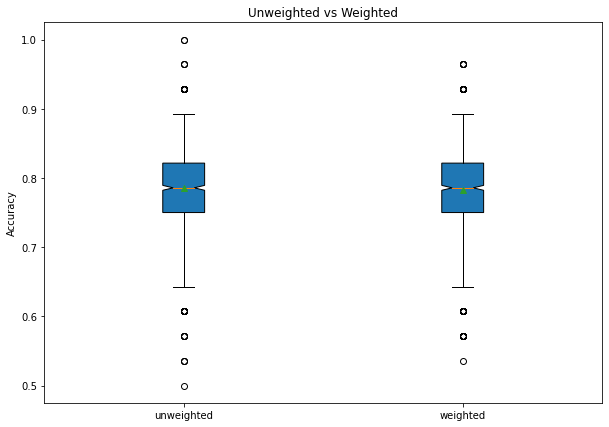

In [25]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([accuracy_unweighted, accuracy_weighted], patch_artist = True,
                notch ='True', vert = 1, showmeans = True)

ax.set_xticklabels(['unweighted', 'weighted'])
plt.title("Unweighted vs Weighted")
plt.ylabel("Accuracy")
plt.savefig('unweighted vs weighted.png',dpi='figure',bbox_inches='tight')